## Temperature Dependent Models for Enzyme Kinetics 

There are two models in this notebook.
1. enzyme_mech_0 : Accounts for increase in catalytic activity with an increase in temperature 
2. enzyme_mech_1 : Adds account of thermodynamic instability of enzyme in previously existing enzyme_mech_0

In [1]:
from biocrnpyler import *
import numpy as np 
import pylab as plt 

# E + S -----> E + P 
# Parameters Required: G = free energy of the reaction
#                      Km =  Michaelis menten constant
#                      T = Temperature of reaction

class enzyme_mech_0(Mechanism):
    def __init__(self, name= "enzyme_basic", mechanism_type="catalysis", **keywords):
        Mechanism.__init__(self, name, mechanism_type)
       
    def update_species(self, Enzyme, Sub, Prod= None, **keywords):
        
        if Prod is None:
            return [Enzyme, Sub]
        else: 
            return [Enzyme, Sub, Prod]
        
    
    def update_reactions(self, Enzyme, Sub, Prod= None, component=None, part_id=None, G= None, T = None,
                         Km = 0.00001, **keywords):
      
        #Get Parameters
        if part_id == None and component != None:
            part_id = component.name

        if component == None and (G == None or T == None or km == None):
            raise ValueError("Must pass in a Component or values")
        if G is None:
            G = component.get_parameter("G", part_id = part_id, mechanism = self)
        if T is None:
            T = component.get_parameter("T", part_id = part_id, mechanism = self)
        if Km is None:
            km = component.get_parameter("Km", part_id = part_id, mechanism = self)
                    
        k_eff=2.08*(10**10)
        R=8.31446261
        e=2.718
        rate_string=  "((" + str(k_eff) +"*"+ str(T) + ")*" + str(e) + "^(-" + str(G)+ "/(" + str(R) + "*" + str(T)+"))*" + "(" + str(Enzyme) + "*" + str(Sub) + ")" + "/" +"(" + str(Km) + "+" + str(Sub) + ")" + ")"
        
        if Prod is not None:
            cat_rxn = Reaction(inputs=[Sub, Enzyme], outputs=[Prod, Enzyme], k=1,propensity_type= "general", propensity_params= { "rate": rate_string})
        else:  # Degradation Reaction
            # Sub:Enz --> Enz
            cat_rxn = Reaction(inputs=[Sub, Enzyme], outputs=[Enzyme], propensity_type= "general", k= Vmax, 
                    propensity_params ={ "rate": rate_string})

        
        return [cat_rxn]



In [5]:
vals

{310, 320, 330, 340}

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


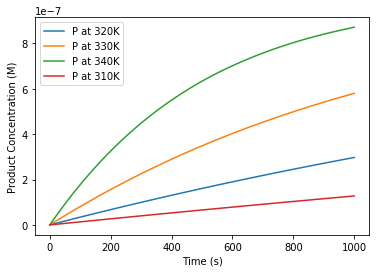

In [2]:
%matplotlib inline
from biocrnpyler import *
vals={310,320,330,340}
for temp in vals:
    E1 = Enzyme("E1", substrate = "S1", product = "P1", parameters ={"G":75000, "T":temp})
    mech_cat = enzyme_mech_0()
    default_mechanisms = {"catalysis":mech_cat}
    M = Mixture("Catalysis Mixture", components = [E1], default_mechanisms = default_mechanisms)
    CRN = M.compile_crn()
    x0 = {"protein_E1":0.000000001 ,"S1":0.000001}
    timepoints = np.linspace(0, 1000, 100)
    R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
    plt.plot(R["time"], R["P1"], label = "P at "+str(temp)+"K")
    
plt.ylabel("Product Concentration (M)")
plt.xlabel("Time (s)")
plt.legend()

In [3]:
from biocrnpyler import *
import numpy as np 
import pylab as plt 

## E + S -----> E + P 
## E -----> X (denatured state)

# Parameters Required: G = free energy of the enzyme-substrate reaction
#                      G_inv = free energy of the E----> X reaction 
#                      Km =  Michaelis menten constant
#                      T = Temperature of reaction

class enzyme_mech_1(Mechanism):
    def __init__(self, name= "enzyme_MM", mechanism_type="catalysis", **keywords):
        Mechanism.__init__(self, name, mechanism_type)
       
    def update_species(self, Enzyme, Sub, Prod= None, **keywords):
        
        X= Species(name="X")
        if Prod is None:
            return [Enzyme, Sub, X]
        else: 
            return [Enzyme, Sub, Prod, X]
        
    
    def update_reactions(self, Enzyme, Sub, Prod= None, component=None, part_id=None, G= None, G_inv= None, T = None,
                         Km = 0.00001, **keywords):
      
        #Get Parameters
        if part_id == None and component != None:
            part_id = component.name

        if component == None and (G == None or T == None or km == None):
            raise ValueError("Must pass in a Component or values")
        if G is None:
            G = component.get_parameter("G", part_id = part_id, mechanism = self)
        if G_inv is None:
            G_inv = component.get_parameter("G_inv", part_id = part_id, mechanism = self)
        if T is None:
            T = component.get_parameter("T", part_id = part_id, mechanism = self)
        if Km is None:
            km = component.get_parameter("Km", part_id = part_id, mechanism = self)
                    
        k_eff=2.08*(10**10)
        R=8.31446261
        e=2.718
        rate_string=  "((" + str(k_eff) +"*"+ str(T) + ")*" + str(e) + "^(-" + str(G)+ "/(" + str(R) + "*" + str(T)+"))*" + "(" + str(Enzyme) + "*" + str(Sub) + ")" + "/" +"(" + str(Km) + "+" + str(Sub) + ")" + ")"
        
        X= Species(name="X")
        kinact = ((k_eff*T)*np.exp(-G_inv/(R*T)))
        
        if Prod is not None:
            cat_rxn = Reaction(inputs=[Sub, Enzyme], outputs=[Prod, Enzyme], k=1,propensity_type= "general", propensity_params= { "rate": rate_string})
        else:  # Degradation Reaction
            # Sub:Enz --> Enz
            cat_rxn = Reaction(inputs=[Sub, Enzyme], outputs=[Enzyme], propensity_type= "general", k= Vmax, 
                    propensity_params ={ "rate": rate_string})
        
        degrade_rxn = Reaction ( inputs = [Enzyme] , outputs = [X] , k= kinact)
        
        return [cat_rxn, degrade_rxn]


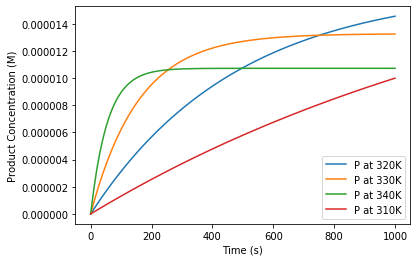

In [4]:
%matplotlib inline
from biocrnpyler import *
vals={310,320,330,340}
for temp in vals:
    E1 = Enzyme("E1", substrate = "S1", product = "P1", parameters ={"G":75000, "G_inv":95000, "T":temp})
    mech_cat = enzyme_mech_1()
    default_mechanisms = {"catalysis":mech_cat}
    M = Mixture("Catalysis Mixture", components = [E1], default_mechanisms = default_mechanisms)
    CRN = M.compile_crn()
    x0 = {"protein_E1":0.00000001 ,"S1":0.0001}
    timepoints = np.linspace(0, 1000, 100)
    R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
    plt.plot(R["time"], R["P1"], label = "P at "+str(temp)+"K")
    
plt.ylabel("Product Concentration (M)")
plt.xlabel("Time (s)")
plt.legend()




